# Buildingblocks of the model in tensorflow


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.backend import sum as tf_sum

import seaborn as sns
import time



In [2]:
def tf_lognormal(x, mu, sigma):
    """ Lognormal PDF function using tensorflow """
    x = tf.clip_by_value(x,1e-12,1e12)
    
    distr = 1/x* tf.math.exp(-((tf.math.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tf_sum(distr, axis=0)+1e-12)

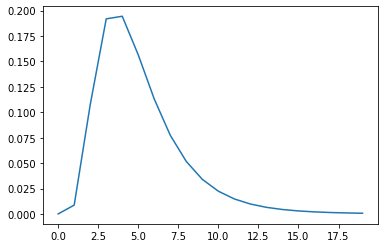

In [3]:
plt.plot(tf_lognormal(np.arange(0,20,dtype=np.float64),tf.math.log(np.array([4.5])),.5))

In [4]:
def SE_serial_model(N, imported_T, R_T, median_serial,sigma_serial,l=10):
    """ Simple 1D (no age/country) SE+serial_interval model. Using tf.scan
        New infections come from the last l days of new exposed multiplied by a probability for each day.
        
        The properties of the (lognormal) probability function are supplied as median_serial and sigma_serial
        Last l exposed and susceptible are forwarded in each iteration (a)
        R_t is supplied for every day in the simulation (len(R_t) = len(simulation)) as well as imported (=initial)
        cases (unpacked through 'x' in scan)
    """
    serial_p = tf_lognormal(np.arange(l,dtype=np.float64),np.log(median_serial),sigma_serial)
    
    def imported_day_acc(a,x):
        # unpack:
        E_t1, E_lastv, S_t = a
        R_t,imported_t = x
        # calc
        f = S_t / N
        
        new = imported_t + tf.tensordot(E_lastv, serial_p, 1) * R_t * f  
        E_nextv = tf.concat([new,E_lastv[:-1]],0)
        
        return [new, E_nextv, S_t-new]
    
    initial = [tf.zeros(1,dtype=np.float64),tf.zeros(l,dtype=np.float64),np.array([N])]
    
    r = tf.scan(imported_day_acc,[R_T,imported_T],initial)

    return r

in 0.165s
tf.Tensor([9.26188384], shape=(1,), dtype=float64)


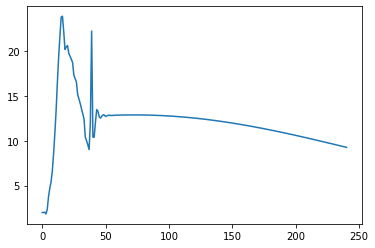

In [5]:
# Test out some dummy data for the 1D model
tf.compat.v1.enable_eager_execution()

R_t = np.array([3,3,3,3,3,3,3,3,3,3,3,3,3,2.8,2.5,2.2,1.8,1.4,1.1,1,.95,.9,.9,.9,.9,.85,.85,.85,.8,.8,.8,.8,.8,.8,.7,.7,.7,.7,1,2,1]+[1.01]*200,dtype=np.float64)
R_t = R_t.reshape([R_t.shape[0],1])
imported_t = np.zeros(R_t.shape[0],dtype=np.float64)
imported_t[:4] = np.array([2,2,2,1],dtype=np.float64)
N = np.array([1e5])
N = N.reshape([N.shape[0],1])
N= 1e5

t1 = time.time()
E_t,E_T,S_t = SE_serial_model(N,imported_t,R_t,4.,.44)
t2 = time.time()
    
    
print("in %.3fs"%(t2-t1))

print(E_t[-1])   
plt.plot(E_t)



# Generate Dummy data with SE*-model only relying on tfp

In [6]:
def TestMatrix():
    d0 = tfp.distributions.LogNormal(tf.math.log(tf.cast(1,tf.float64)),.1).sample(4)
    d1 = tfp.distributions.LogNormal(tf.math.log(tf.cast(.5,tf.float64)),.1).sample(4)
    d2 = tfp.distributions.LogNormal(tf.math.log(tf.cast(.25,tf.float64)),.1).sample(2)
    d2 = tf.stack([d2,d2])
    
    eye = tf.eye(4,dtype=np.float64)*d0
    upper = tf.roll(tf.eye(4,dtype=tf.float64),1,axis=1)*tf.reshape(d1,[4,1])
    lower = tf.roll(tf.eye(4,dtype=tf.float64),1,axis=0)*tf.reshape(d1,[1,4])
    outer = tf.roll(tf.eye(4,dtype=tf.float64),2,axis=0)*tf.reshape(d2,[1,4])
    
    full = eye+upper+lower+outer
    p = tf.einsum("ij,jk,jl->il",tf.eye(4,dtype=full.dtype),full,tf.eye(4,dtype=full.dtype))
    f = tf_sum(p)/4.
    
    print(full)
    print(p)
    
    return full/f

def GenDummy4cp_AgeGroups(l,age_groups=3):
    """ Gen dummy data for 1 country with age_groups """
    # 1st day Feb 15 --> March 1st is day 29, 9th is day 38.
    # Basic test with 3 'down' and 1 'up' changepoint with different slopes
    R_0, c_day, c_day_sigma  = 3.,[38,43,52,73],[4,3,2,7]
    c_slope, c_change, c_change_sigma = [3,3,5,7],[-1.,-.75,-.75,1.25],[.25,.25,.1,.5]

    # Generate basic reproduction Number
    R_0_dist = tfp.distributions.Normal(tf.cast(R_0,np.float64),.8)
    R_0s = R_0_dist.sample(age_groups)
    
    # Generate position for each CP
    day_dist = tfp.distributions.Normal(tf.cast(c_day,np.float64),c_day_sigma)
    days = day_dist.sample(age_groups)
    
    # Generate slopes for each CP
    slope_dist = tfp.distributions.LogNormal(tf.math.log(tf.cast(c_slope,np.float64)),.5)
    slopes = slope_dist.sample(age_groups)
    
    # Generate change for each CP
    change_dist = tfp.distributions.Normal(tf.cast(c_change,np.float64),c_change_sigma)
    changes = change_dist.sample(age_groups)
    
    # Generate range [0..l) for each age_group as range for sigmoids
    r = tf.cast((tf.reshape(tf.repeat(tf.range(0,l,1),age_groups),[l,age_groups])),np.float64)
    R_t = tf.ones([l,age_groups],dtype=np.float64)*R_0s
    
    cps = tf.transpose([days,slopes,changes],perm=[2,0,1])
    for day,slope,change in cps:
        s = tf.sigmoid((r-day)/slope)*change
        R_t *= tf.math.exp(s)
    
    # add country index and Permutate indices: time,country,age_group
    R_t = tf.transpose(tf.reshape(R_t,[l,age_groups,1]),perm=[0,2,1])
    
    # Alternative Aproach to I_0 for each age_group
    I_0 = tfp.distributions.HalfCauchy(tf.cast(10,np.float64),10).sample(age_groups)
    I_0 = tf.reshape(I_0,[1,I_0.shape[0]])
    
    return R_t, I_0
 
def GenDummyCountries(l,countries,age_groups=5):
    # Repeat data generation for multiple countries
    r0,i0 = GenDummy4cp_AgeGroups(l,age_groups)
    for n in range(countries-1):
        r_next,i_next = GenDummy4cp_AgeGroups(l,age_groups)
        r0 = tf.concat([r0,r_next],axis=1)
        i0 = tf.concat([i0,i_next],axis=0)
    return r0,i0

def SE_serial_model_countries_age_groups(N, I_0, R_T, C, g ,l=16):
    """ 
        N  : total population [contries x age_groups]
        I_0: Initial number of cases per country and age_group
        R_T: [time x countries x age_group]
        C  : contact matrix [age_groups x age_groups]
        g  : Distribution for g for the serial interval
        l  : length of g(\tau)
    """
    # Generate serial interval weight g(\tau)
    g_p = g.prob(tf.range(1e-12,l+1e-12,dtype=g.dtype)) # shift range by 1e-12 to allow distributions which are undefined for \tau = 0
    g_p /= tf_sum(g_p)
    
    # Calculate fration of each age_group of the total population
    N_sum = tf_sum(N,axis=1)
    
    def imported_day_acc(a,R_t):
        # unpack:
        E_t1, E_lastv, S_t = a
        # E_lastv is time,country,age_group
       
        # calc susceptible fraction (country x age_group)
        f = S_t / N
         
        # Calc "infectious" people, weighted by serial_p (country x age_group)
        infectious = tf.einsum("tca,t->ca",E_lastv,g_p) 
#        infectious = tf.tensordot(E_lastv,g_p,1)
        
        # Calculate effective R_t [country,age_group] from Contact-Matrix C [country,age_group,age_group]
        R_sqrt = tf.sqrt(R_t)
        R_diag = tf.einsum("ij,ci->cij",tf.eye(R_t.shape[-1],dtype=R_t.dtype), R_sqrt)
        R_eff = tf.einsum("cij,ik,ckl->cil", R_diag, C, R_diag) # Effective growth
        
        # Calculate new infections
        new = tf.einsum("nj,njk,nk->nk",infectious,R_eff,f)
            
        new_v = tf.reshape(new,[1,new.shape[0],new.shape[1]])
        E_nextv = tf.concat([new_v,E_lastv[:-1,:,:]], 0 )  # Create new exposed population for new step
        
        return [new, E_nextv, S_t-new]
    
    # Generate exponential distributed intial I_0_t, sum = I_0
    # I't not the real thing right now, as the slope of the exponential doesn't match R_t,
    # but close enough to avoid starting oscillations
    
    exp_r = tf.range(start=l,limit=0.,delta=-1.,dtype=g.dtype)
    exp_d = tf.math.exp(exp_r)
    exp_d = exp_d * g_p # wieght by serial_p
    exp_d /= tf_sum(exp_d,axis=0)   # normalize by dividing by sum over time-dimension
    I_0_t = tf.einsum("ca,t->tca",I_0,exp_d)
    #    I_0_t = tf.tensordot(I_0, exp_d, axes=0) # Calculate the outer product (axes=0) --> initial distribution
    
    # Exchanged for I_0_t
    initial = [tf.zeros(N.shape,dtype=np.float64), I_0_t, N]
    
    out = tf.scan(imported_day_acc,R_T,initial)
    return out

def GenNoisyDummyCountries(l,countries,age_groups=5,median_serial=4.5,sigma_serial=.44,noise=.1):
    """returns the cummulative onsets of symptoms"""

    # Generate Populations
    Ns = tf.ones([n_countries,n_age_groups],np.float64)*1e6
    N_dist = tfp.distributions.Normal(tf.cast(1,np.float64),.1)
    N_f = N_dist.sample(Ns.shape)
    Ns *= N_f
    
    # g-distribution for serial interval
    dist_g = tfp.distributions.Gamma(concentration=tf.cast(median_serial, np.float64), rate= sigma_serial)

    # contact-matrix
#    C = tf.eye(age_groups,dtype=np.float64)
    C = TestMatrix()
    
    # Generate R_t and I_0 for the countries and run the model
    R_t,I_0 = GenDummyCountries(l, n_countries, n_age_groups)
    print("Run S*(whatever)-model\n")
    E_t,_,S_t = SE_serial_model_countries_age_groups(Ns, I_0, R_t, C, dist_g)
    
    # Add some noise
    noise_dist = tfp.distributions.Normal(tf.cast(1, np.float64),.02)
    noise = tf.clip_by_value(noise_dist.sample(E_t.shape),0,1e9)
        
    E_n_t = E_t * noise
    return tf.math.cumsum(E_n_t,axis=0), R_t

# Run the data-generator
l,n_countries, n_age_groups = 121,3,4
infected_T,R_T = GenNoisyDummyCountries(l, n_countries, n_age_groups)

tf.Tensor(
[[0.94660092 0.60149858 0.25992853 0.54155349]
 [0.60149858 0.91427943 0.47947331 0.27393633]
 [0.25992853 0.47947331 0.94399881 0.49821258]
 [0.54155349 0.27393633 0.49821258 1.1544078 ]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[2.34958152 0.         0.         0.        ]
 [0.         2.26918765 0.         0.        ]
 [0.         0.         2.18161323 0.        ]
 [0.         0.         0.         2.4681102 ]], shape=(4, 4), dtype=float64)
Run S*(whatever)-model



Text(0, 0.5, 'R_t')

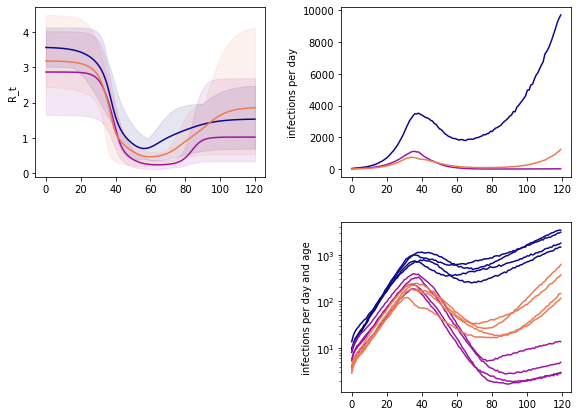

In [7]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
plasma = plt.cm.plasma
gs = fig.add_gridspec(2,2)

ax = fig.add_subplot(gs[0,1])
bx = fig.add_subplot(gs[1,1])

dx = fig.add_subplot(gs[0,0])

for i,c in enumerate(tf.transpose(infected_T,perm=[1,2,0])):
    color = plasma(i/infected_T.shape[1])
    x = np.zeros(infected_T.shape[0]-1)
    for a in c:
        x2 = np.diff(a)
        bx.semilogy(x2,color=color)
        x += x2
#    ax.semilogy(x,"-",color=color)
    ax.plot(x,"-",color=color)
    
for i,r in enumerate(tf.transpose(R_T,perm=[1,2,0])):
    color = plasma(i/R_T.shape[1])
    dx.plot(np.mean(r,axis=0),color=color)
    dx.fill_between(range(R_T.shape[0]),*(np.min(r,axis=0),np.max(r,axis=0)),color=color,alpha=.1)

ax.set_ylabel("infections per day")
bx.set_ylabel("infections per day and age")
dx.set_ylabel("R_t")

# Some LKJ - Stuff

In [8]:
connection = pm.LKJ("connection",R_T.shape[2],tf.cast(2,np.float64)).sample(4)
c0,Rt = connection[0], R_T[0,0]
#Rt = zd
Rt = tf.cast([2,1,1,1],dtype=np.float64) #,sd_dist=pm.HalfCauchy.dist(2)

RTdiag = tf.eye(Rt.shape[0],dtype=np.float64)*Rt

print(Rt)

print(connection)

m = tf.einsum("ij,njk,kl->nil",RTdiag,connection,RTdiag)
m2 = RTdiag@connection@RTdiag
print(m)
print("should be 0",m2-m)

tf.Tensor([2. 1. 1. 1.], shape=(4,), dtype=float64)
tf.Tensor(
[[[ 1.         -0.38596153  0.14427435  0.23094111]
  [-0.38596153  1.          0.01933665 -0.50394565]
  [ 0.14427435  0.01933665  1.          0.41564684]
  [ 0.23094111 -0.50394565  0.41564684  1.        ]]

 [[ 1.         -0.64598678  0.49770271  0.2880118 ]
  [-0.64598678  1.         -0.18778665 -0.24842788]
  [ 0.49770271 -0.18778665  1.         -0.25578651]
  [ 0.2880118  -0.24842788 -0.25578651  1.        ]]

 [[ 1.          0.31468087 -0.15213172  0.33354075]
  [ 0.31468087  1.         -0.56539031  0.33487499]
  [-0.15213172 -0.56539031  1.          0.17402027]
  [ 0.33354075  0.33487499  0.17402027  1.        ]]

 [[ 1.         -0.13809243  0.17099132  0.14843184]
  [-0.13809243  1.          0.65182355 -0.21382968]
  [ 0.17099132  0.65182355  1.         -0.16788697]
  [ 0.14843184 -0.21382968 -0.16788697  1.        ]]], shape=(4, 4, 4), dtype=float64)
tf.Tensor(
[[[ 4.         -0.77192306  0.2885487   0.46188222]
 

In [9]:
# Connection Matrix from LKJ
connection = pm.LKJ("connection",Rt.shape[0],tf.cast(2,np.float64),sd_dist=1).sample(6)

Rt = tf.cast([1,1,1,1],dtype=np.float64)*3
infectious = tf.cast([1000,1000,500,1000],np.float64)
print("Infectious population",infectious.numpy(),"\sum = ",np.sum(infectious.numpy()))
print("R_t in age_groups",Rt.numpy())
print("different smaples from LKJ-distribution")
print(connection)
# Two options: 1) \Lambda * C * \Lambda
o1 = tf.cast( tf.tensordot(Rt*connection*Rt,infectious,1) , np.int32)

Rt_diag = tf.eye(Rt.shape[-1],dtype=Rt.dtype)*Rt
o3 = tf.einsum("ij,njk,kl,l->nil",Rt_diag,connection,Rt_diag,infectious)
# 2) C * \Lambda * C
o2 = tf.cast( tf.tensordot(connection*Rt*connection,infectious,1) , np.int32)

#print("Result option 1")
#print(o1)
#print("sum=",tf_sum(o1,axis=1).numpy())

#print("Result option 2")
#print(o2)
#print("sum=",tf_sum(o2,axis=1).numpy())

print("Result option 3")
print(o3)
print("sum=",tf_sum(o3,axis=1).numpy())

Infectious population [1000. 1000.  500. 1000.] \sum =  3500.0
R_t in age_groups [3. 3. 3. 3.]
different smaples from LKJ-distribution
tf.Tensor(
[[[ 1.         -0.04633343  0.39235407  0.37165255]
  [-0.04633343  1.          0.25180181 -0.51388678]
  [ 0.39235407  0.25180181  1.         -0.1823644 ]
  [ 0.37165255 -0.51388678 -0.1823644   1.        ]]

 [[ 1.          0.13507001 -0.10251119 -0.26162575]
  [ 0.13507001  1.          0.01344016  0.55164776]
  [-0.10251119  0.01344016  1.          0.07604848]
  [-0.26162575  0.55164776  0.07604848  1.        ]]

 [[ 1.         -0.07536884 -0.46205755  0.43045464]
  [-0.07536884  1.          0.4003567   0.42947524]
  [-0.46205755  0.4003567   1.          0.38523804]
  [ 0.43045464  0.42947524  0.38523804  1.        ]]

 [[ 1.          0.20160855 -0.24470325  0.48284246]
  [ 0.20160855  1.         -0.20057152 -0.33348063]
  [-0.24470325 -0.20057152  1.         -0.49840875]
  [ 0.48284246 -0.33348063 -0.49840875  1.        ]]

 [[ 1.        